# Benchmark Properties

In [1]:
import json
from collections import Counter

tasks = json.load(open("benchmark.json"))
print("Total tasks:", len(tasks))

count = {
  "num_rules":       Counter(t["metadata"]["num_rules"] for t in tasks),
  "num_base_facts":  Counter(t["metadata"]["num_base_facts"] for t in tasks),
  "proof_depth":     Counter(t["metadata"]["proof_depth"] for t in tasks),
  "allow_recursion": Counter(t["metadata"]["allow_recursion"] for t in tasks),
  "reasoning_type":  Counter(t["metadata"]["reasoning_type"] for t in tasks),
  "label":           Counter(t["t"] for t in tasks),
}

for k, v in count.items():
    print(f"\n{k}:")
    for val, freq in sorted(v.items()):
        print(f"  {val}: {freq}")

Total tasks: 1120

num_rules:
  5: 160
  15: 240
  25: 320
  35: 400

num_base_facts:
  3: 224
  6: 224
  9: 224
  12: 224
  15: 224

proof_depth:
  1: 320
  5: 320
  10: 240
  20: 160
  30: 80

allow_recursion:
  False: 560
  True: 560

reasoning_type:
  abduction: 420
  deduction: 700

label:
  NO: 544
  YES: 576


# LLM Benchmark Analysis

N models  
* llama-2 13B chat
* Flan-T5 XL

evaluated on N deduction and N abduction tasks.  
This notebook loads the JSON result files, computes basic accuracy metrics, and explores performance vs. task characteristics such as proof-depth and rule / fact counts.

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

files = {
    # "llama2 (unshuffled)" : Path("llama2_results_unshuffled.json"),
    # "llama2 (shuffled)" : Path("llama2_results_shuffled.json"),
    "flan t5 xl (unshuffled)": Path("flan_t5_results_unshuffled.json"),
    "flan t5 xl (shuffled)": Path("flan_t5_results_shuffled.json"),
    # ADD OTHERS HERE WHEN HAVE RESULTS
}

records = []
for model, fp in files.items():
    with open(fp) as f:
        data = json.load(f)
    for d in data:
        records.append({**d, "model": model})

df = pd.DataFrame(records)
print(f"Loaded {df.shape[0]} total rows across {df['model'].nunique()} model-runs.\n")

# df = shuffle(df)
df.head()

Loaded 2240 total rows across 2 model-runs.



,q,c,natural language,t,num_rules,max_body_length,allow_recursion,branching_factor,proof_depth,num_base_facts,depth,reasoning_type,pred,rationale,model
0,"likes(frank,pencil).","hungry(carol) :- friend(eve,alice).\nhungry(bo...",You are given the following information:\nIf e...,YES,5,3,True,2,1,3,1,deduction,YES,,flan t5 xl (unshuffled)
1,"friend(eve,alice).","hungry(carol) :- friend(eve,alice).\nhungry(bo...",You are given the following information:\nIf e...,YES,5,3,True,2,1,3,1,deduction,YES,,flan t5 xl (unshuffled)
2,"likes(eve,car).","hungry(carol) :- friend(eve,alice).\nhungry(bo...",You are given the following information:\nIf e...,YES,5,3,True,2,1,3,1,deduction,YES,,flan t5 xl (unshuffled)
3,"friend(alice,carol).","hungry(carol) :- friend(eve,alice).\nhungry(bo...",You are given the following information:\nIf e...,NO,5,3,True,2,1,3,not applicable,deduction,NO,,flan t5 xl (unshuffled)
4,"sibling(alice,carol).","hungry(carol) :- friend(eve,alice).\nhungry(bo...",You are given the following information:\nIf e...,NO,5,3,True,2,1,3,not applicable,deduction,NO,,flan t5 xl (unshuffled)


## Overall Accuracy

In [27]:
df["correct"] = df["t"] == df["pred"]

overall_acc = df.groupby("model")["correct"].mean().mul(100).round(2)
print("Overall accuracy (%) by model:\n")
display(overall_acc.to_frame("Accuracy (%)"))

Overall accuracy (%) by model:



,Accuracy (%)
model,
flan t5 xl (shuffled),65.54
flan t5 xl (unshuffled),65.54


## Precision and Recall

In [29]:
from sklearn.metrics import precision_recall_fscore_support
metrics = []
for model_name, sub in df.groupby("model"):
    y_true = sub["t"].str.upper().map({"YES": 1, "NO": 0})
    y_pred = sub["pred"].str.upper().map({"YES": 1, "NO": 0}).fillna(-1).astype(int)

    # If pred == ERROR (mapped to -1), sklearn will ignore that row by default in precision_recall_fscore_support?
    # We can filter out entries where pred is not “YES”/“NO”
    mask = y_pred.isin([0,1])
    p, r, f1, _ = precision_recall_fscore_support(
        y_true[mask], y_pred[mask], pos_label=1, average='binary'
    )
    metrics.append({
        "model": model_name,
        "precision (YES)": p,
        "recall (YES)"   : r,
        "f1 (YES)"       : f1,
    })

pr_df = pd.DataFrame(metrics).set_index("model")
display(pr_df)


,precision (YES),recall (YES),f1 (YES)
model,,,
flan t5 xl (shuffled),0.6082,0.927083,0.734525
flan t5 xl (unshuffled),0.6082,0.927083,0.734525


## Accuracy by Proof Depth

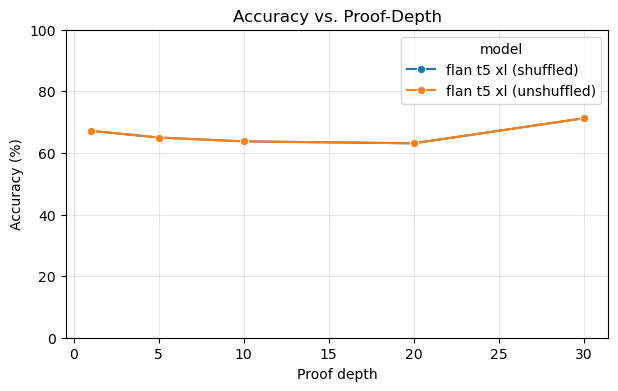

In [30]:
depth_acc = (
    df.groupby(["model", "proof_depth"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"]*100)
)

plt.figure(figsize=(7,4))
sns.lineplot(
    data=depth_acc,
    x="proof_depth", y="accuracy", hue="model", marker="o"
)
plt.title("Accuracy vs. Proof-Depth")
plt.ylabel("Accuracy (%)")
plt.xlabel("Proof depth")
plt.ylim(0,100)
plt.grid(alpha=.3)
plt.show()

## Accuracy by Number of Rules

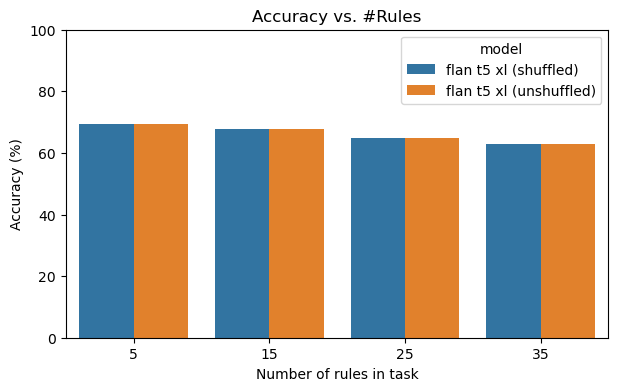


Model: flan t5 xl (unshuffled)
  Num Rules 5: 69.4%
  Num Rules 15: 67.9%
  Num Rules 25: 65.0%
  Num Rules 35: 63.0%

Model: flan t5 xl (shuffled)
  Num Rules 5: 69.4%
  Num Rules 15: 67.9%
  Num Rules 25: 65.0%
  Num Rules 35: 63.0%


In [31]:
rules_acc = (
    df.groupby(["model", "num_rules"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"]*100)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=rules_acc, x="num_rules", y="accuracy", hue="model"
)
plt.title("Accuracy vs. #Rules")
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of rules in task")
plt.ylim(0, 100)
plt.show()

# print the accuracy for each model for each number of rules
for model in df["model"].unique():
    print(f"\nModel: {model}")
    for num_rules in sorted(df["num_rules"].unique()):
        acc = df[(df["model"] == model) & (df["num_rules"] == num_rules)]["correct"].mean() * 100
        print(f"  Num Rules {num_rules}: {acc:.1f}%")

## Accuracy vs. Number of Base Facts

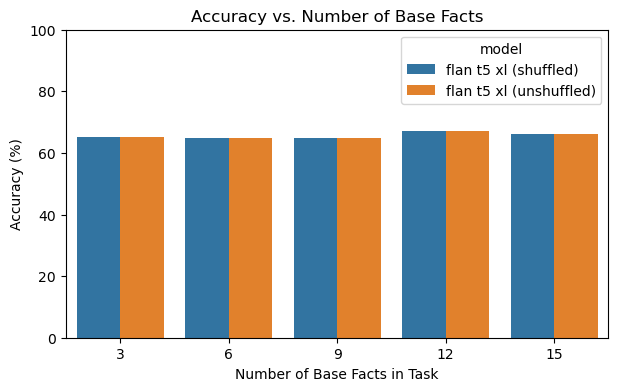


Accuracy by model for each num_base_facts:

Model: flan t5 xl (unshuffled)
  num_base_facts =  3:  65.2%
  num_base_facts =  6:  64.7%
  num_base_facts =  9:  64.7%
  num_base_facts = 12:  67.0%
  num_base_facts = 15:  66.1%

Model: flan t5 xl (shuffled)
  num_base_facts =  3:  65.2%
  num_base_facts =  6:  64.7%
  num_base_facts =  9:  64.7%
  num_base_facts = 12:  67.0%
  num_base_facts = 15:  66.1%


In [32]:
facts_acc = (
    df.groupby(["model", "num_base_facts"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"] * 100)
)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=facts_acc,
    x="num_base_facts", y="accuracy", hue="model"
)
plt.title("Accuracy vs. Number of Base Facts")
plt.ylabel("Accuracy (%)")
plt.xlabel("Number of Base Facts in Task")
plt.ylim(0, 100)
plt.show()

# Numeric summary
print("\nAccuracy by model for each num_base_facts:")
for model_name in df["model"].unique():
    print(f"\nModel: {model_name}")
    for nb in sorted(df["num_base_facts"].unique()):
        a = df[(df["model"] == model_name) & (df["num_base_facts"] == nb)]["correct"].mean() * 100
        print(f"  num_base_facts = {nb:2d}: {a:5.1f}%")


## Accuracy by Reasoning Type (Deduction vs Abduction)

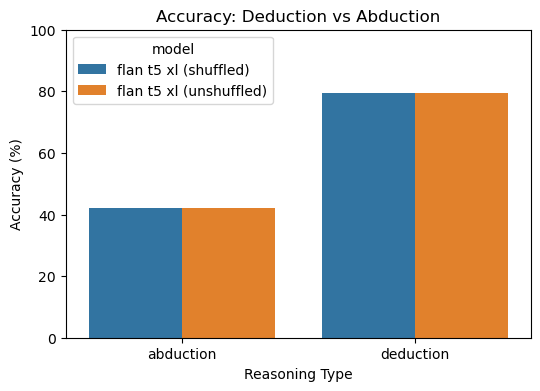

model,flan t5 xl (shuffled),flan t5 xl (unshuffled)
reasoning_type,,
abduction,42.142857,42.142857
deduction,79.571429,79.571429


In [33]:
type_acc = (
    df.groupby(["model", "reasoning_type"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"] * 100)
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=type_acc,
    x="reasoning_type", y="accuracy", hue="model"
)
plt.title("Accuracy: Deduction vs Abduction")
plt.ylabel("Accuracy (%)")
plt.xlabel("Reasoning Type")
plt.ylim(0,100)
plt.show()

display(type_acc.pivot(index="reasoning_type", columns="model", values="accuracy"))

## Confusion matrix

In [35]:
from sklearn.metrics import confusion_matrix

# combined confusion‐matrix across all models
for model_name, sub in df.groupby("model"):
    # Only count rows that returned a valid YES/NO
    valid = sub[sub["pred"].isin(["YES","NO"])]
    cm = confusion_matrix(valid["t"], valid["pred"], labels=["YES","NO"])
    cm_df = pd.DataFrame(cm, index=["gold=YES","gold=NO"], columns=["pred=YES","pred=NO"])
    print(f"\nConfusion matrix for '{model_name}':\n")
    display(cm_df)


Confusion matrix for 'flan t5 xl (shuffled)':



,pred=YES,pred=NO
gold=YES,534,42
gold=NO,344,200



Confusion matrix for 'flan t5 xl (unshuffled)':



,pred=YES,pred=NO
gold=YES,534,42
gold=NO,344,200


## Hardest tasks per model (Highest failure rate)

In [36]:
# compute bucket‐wise accuracy
bucket_cols = ["num_rules","num_base_facts","proof_depth","allow_recursion","reasoning_type"]
bucket_acc = (
    df.groupby(["model"] + bucket_cols)["correct"]
      .agg(["mean","count"])
      .reset_index()
      .assign(accuracy=lambda x: x["mean"] * 100)
)

# find the bottom‐5 worst‐performing buckets (for each model)
for model_name, sub in bucket_acc.groupby("model"):
    sub_sorted = sub.sort_values("accuracy").head(5)
    print(f"\nWorst 5 buckets for {model_name}:\n")
    display(sub_sorted[bucket_cols + ["accuracy","count"]])


Worst 5 buckets for flan t5 xl (shuffled):



,num_rules,num_base_facts,proof_depth,allow_recursion,reasoning_type,accuracy,count
78,15,12,1,True,abduction,0.000000,3
262,35,15,1,True,abduction,0.000000,3
270,35,15,10,True,abduction,0.000000,3
0,5,3,1,False,abduction,33.333333,3
24,5,12,1,False,abduction,33.333333,3



Worst 5 buckets for flan t5 xl (unshuffled):



,num_rules,num_base_facts,proof_depth,allow_recursion,reasoning_type,accuracy,count
358,15,12,1,True,abduction,0.000000,3
542,35,15,1,True,abduction,0.000000,3
550,35,15,10,True,abduction,0.000000,3
280,5,3,1,False,abduction,33.333333,3
304,5,12,1,False,abduction,33.333333,3


In [39]:
# show actual prompts of some hardest tasks
for model_name, sub in bucket_acc.groupby("model"):
    worst_buckets = sub.sort_values("accuracy").head(3)[bucket_cols]
    print(f"\n=== {model_name} — Example tasks from the 3 worst‐performing buckets ===\n")
    for _, bucket in worst_buckets.iterrows():
        nr = bucket["num_rules"]
        nb = bucket["num_base_facts"]
        pd = bucket["proof_depth"]
        ar = bucket["allow_recursion"]
        rt = bucket["reasoning_type"]

        print(f"Bucket: num_rules={nr}, num_base_facts={nb}, proof_depth={pd}, allow_recursion={ar}, reasoning_type={rt}\n")
        # Filter the failures in this bucket
        fails = df[
            (df["model"] == model_name) &
            (df["num_rules"] == nr) &
            (df["num_base_facts"] == nb) &
            (df["proof_depth"] == pd) &
            (df["allow_recursion"] == ar) &
            (df["reasoning_type"] == rt) &
            (~df["correct"])
        ]
        # Show up to 2 examples
        for i, row in fails.head(2).iterrows():
            print(f" Task index: {i}")
            print("  → Prompt:\n")
            print(row["natural language"])
            print("\n  → Gold:", row["t"])
            print("  → Pred:", row["pred"])
            print("  → Rationale:", row["rationale"])
            print("-" * 80)
        print("\n")



=== flan t5 xl (shuffled) — Example tasks from the 3 worst‐performing buckets ===

Bucket: num_rules=15, num_base_facts=12, proof_depth=1, allow_recursion=True, reasoning_type=abduction

 Task index: 1429
  → Prompt:

You are given the following rules:
If frank is sad, then frank is hungry.
If it is cold and book is wet, then it is sunny.
If eve is an enemy of alice and frank is a parent of george, then it is sunny.
If alice is an enemy of frank, then dave is sad.
If alice is sad, then alice is sad.
If it is sunny, then ball is small.
If it is hot and car is small and book is big, then apple is small.
If ball is small and car is big, then apple is small.
If it is sunny and it is sunny, then it is sunny.
If car is wet and dave is a friend of carol, then eve is a sibling of eve.
If alice is a friend of alice and it is sunny, then alice is hungry.
If carol is a sibling of dave, then alice is a sibling of alice.
If bob dislikes carol and dave is a parent of bob and dave is hungry, then al

## Other insights:

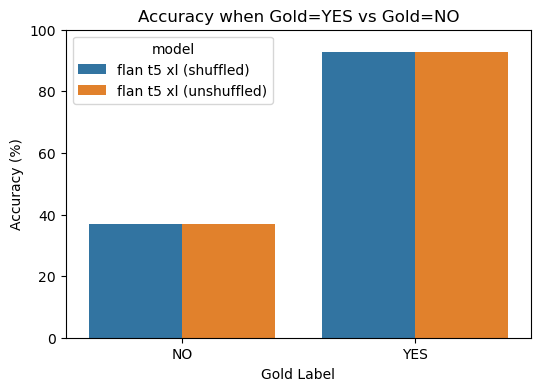

model,flan t5 xl (shuffled),flan t5 xl (unshuffled)
t,,
NO,36.764706,36.764706
YES,92.708333,92.708333


In [40]:
# Accuracy vs gold label
label_acc = (
    df.groupby(["model", "t"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"] * 100)
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=label_acc,
    x="t", y="accuracy", hue="model"
)
plt.title("Accuracy when Gold=YES vs Gold=NO")
plt.ylabel("Accuracy (%)")
plt.xlabel("Gold Label")
plt.ylim(0, 100)
plt.show()

display(label_acc.pivot(index="t", columns="model", values="accuracy"))

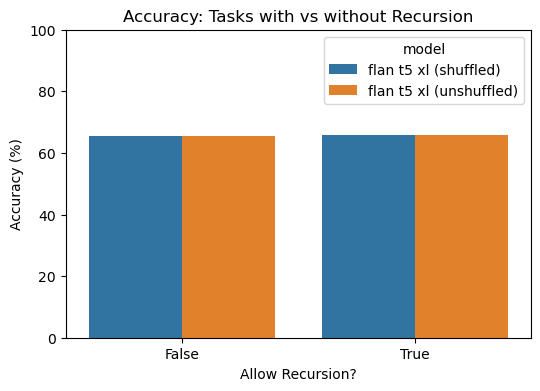

model,flan t5 xl (shuffled),flan t5 xl (unshuffled)
allow_recursion,,
False,65.357143,65.357143
True,65.714286,65.714286


In [41]:
# Accuracy vs whether program is recursive

rec_acc = (
    df.groupby(["model", "allow_recursion"])["correct"]
      .mean()
      .reset_index()
      .assign(accuracy=lambda x: x["correct"] * 100)
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=rec_acc,
    x="allow_recursion", y="accuracy", hue="model"
)
plt.title("Accuracy: Tasks with vs without Recursion")
plt.ylabel("Accuracy (%)")
plt.xlabel("Allow Recursion?")
plt.ylim(0, 100)
plt.show()

display(rec_acc.pivot(index="allow_recursion", columns="model", values="accuracy"))